In [28]:
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
import warnings
from collections import Counter
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
from keras import Sequential
from keras.layers import Dense
import pickle
from sklearn.externals import joblib
from sklearn.model_selection import cross_val_score


In [29]:
df=pd.read_csv('bankloan.csv')
df=df.dropna()
df.isna().any()
df=df.drop('Loan_ID',axis=1)
df['LoanAmount']=(df['LoanAmount']*1000).astype(int)
print(Counter(df['Loan_Status']))
print(Counter(df['Loan_Status'])['Y']/df['Loan_Status'].size)

Counter({'Y': 332, 'N': 148})
0.6916666666666667


In [30]:
df['TotalIncome']=df['ApplicantIncome']+df['CoapplicantIncome']

In [31]:
pre_y=df['Loan_Status']
pre_x=df.drop('Loan_Status',axis=1)
pre_x.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,TotalIncome
1,Male,Yes,1.0,Graduate,No,4583,1508.0,128000,360.0,1.0,Rural,6091.0
2,Male,Yes,0.0,Graduate,Yes,3000,0.0,66000,360.0,1.0,Urban,3000.0
3,Male,Yes,0.0,Not Graduate,No,2583,2358.0,120000,360.0,1.0,Urban,4941.0
4,Male,No,0.0,Graduate,No,6000,0.0,141000,360.0,1.0,Urban,6000.0
5,Male,Yes,2.0,Graduate,Yes,5417,4196.0,267000,360.0,1.0,Urban,9613.0


In [32]:
###https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html
dum_x=pd.get_dummies(pre_x)
dum_y=pd.DataFrame(columns=['LoanStatus'])
dummyfied_y=pre_y.map(dict(Y=1,N=0))

In [33]:
dum_y['LoanStatus']=dummyfied_y
dum_y.head()

,LoanStatus
1,0
2,1
3,1
4,1
5,1


In [34]:
dum_x.head()
dum_x.to_csv('dummyx.csv',index=False)
dum_y.to_csv('dummyy.csv',index=False)

In [35]:
#https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html
#### equal amount of Y and N , nd equal to the no of less values x
smote=SMOTE(ratio='minority')
X1,y=smote.fit_sample(dum_x,dum_y)

In [36]:
sc=MinMaxScaler()
X=sc.fit_transform(X1)
filename='scale_model.pkl'
joblib.dump(sc,filename)

['scale_model.pkl']

In [37]:
Counter(y)

Counter({0: 332, 1: 332})

In [38]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,shuffle=True)

In [39]:
X_train.shape[1]

18

In [40]:
###### Alert !!!! only testing

dic={1:[200,400,4,1,50],2:[400,800,10,1,50],3:[400,800,100,1,50],
    4:[200,400,4,1,100],5:[400,800,10,1,100],6:[400,800,100,1,100]}

def get_pred_threshold(X_test,y_test,classifier): ### gives the threshold for which accuracy gone maximum
    th_list=list(np.arange(0,2,0.05))
    max_accuracy=0
    max_th=0
    predicted=classifier.predict(X_test)
    for th in th_list:
        y_pred=[]
        y_pred=predicted
        y_pred=(y_pred>th)
        cm=confusion_matrix(y_test,y_pred)
        acc=((cm[0,0]+cm[1,1])*100)/(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1])
        if acc>max_accuracy:
            max_accuracy=acc
            max_th=th
    return max_th


def get_best_classifier():
    max_acc=0
    best_key=0
    best_classifier=0
    max_th=0
    for k in dic.keys():
        classifier=Sequential()
        classifier.add(Dense(dic[k][0],activation='relu',kernel_initializer='random_normal',input_dim=X_train.shape[1]))
        classifier.add(Dense(dic[k][1],activation='relu',kernel_initializer='random_normal'))
        classifier.add(Dense(dic[k][2],activation='relu',kernel_initializer='random_normal'))
        classifier.add(Dense(dic[k][3],activation='sigmoid',kernel_initializer='random_normal'))
        classifier.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
        #### as binary prediction so binary_cross entropy
        classifier.fit(X_train,y_train,batch_size=20,epochs=dic[k][4],verbose=0)
        
        th=get_pred_threshold(X_test,y_test,classifier)

        y_pred=classifier.predict(X_test)
        y_pred=(y_pred>th)
        cm=confusion_matrix(y_test,y_pred)
        acc=((cm[0,0]+cm[1,1])*100)/(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1])
        if acc> max_acc:
            max_acc=acc
            best_key=k
            best_classifier=classifier
            max_th=th
            filename='maximum_th.pkl'
            joblib.dump(max_th,filename)
    return best_classifier
            

classifier=get_best_classifier()

eval_model=classifier.evaluate(X_train,y_train)
print(f'accuracy {eval_model[1]*100}')
filename='loan_model.pkl'
joblib.dump(classifier,filename)

531/531 [==============================] - 1s 1ms/step
accuracy 89.6421845574388


['loan_model.pkl']

In [41]:
'''classifier=Sequential()
classifier.add(Dense(200,activation='relu',kernel_initializer='random_normal',input_dim=X_train.shape[1]))
classifier.add(Dense(400,activation='relu',kernel_initializer='random_normal'))
classifier.add(Dense(4,activation='relu',kernel_initializer='random_normal'))
classifier.add(Dense(1,activation='sigmoid',kernel_initializer='random_normal'))
classifier.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
#### as binary prediction so binary_cross entropy
classifier.fit(X_train,y_train,batch_size=20,epochs=50,verbose=0)
eval_model=classifier.evaluate(X_train,y_train)
eval_model'''

"classifier=Sequential()\nclassifier.add(Dense(200,activation='relu',kernel_initializer='random_normal',input_dim=X_train.shape[1]))\nclassifier.add(Dense(400,activation='relu',kernel_initializer='random_normal'))\nclassifier.add(Dense(4,activation='relu',kernel_initializer='random_normal'))\nclassifier.add(Dense(1,activation='sigmoid',kernel_initializer='random_normal'))\nclassifier.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])\n#### as binary prediction so binary_cross entropy\nclassifier.fit(X_train,y_train,batch_size=20,epochs=50,verbose=0)\neval_model=classifier.evaluate(X_train,y_train)\neval_model"

In [42]:
max_th=joblib.load('maximum_th.pkl')

In [43]:

y_pred=classifier.predict(X_test)
y_pred=(y_pred>max_th)


In [44]:
cm=confusion_matrix(y_test,y_pred)


In [45]:
cm

array([[46, 19],
       [ 5, 63]], dtype=int64)

[Text(0, 0.5, 'No'), Text(0, 1.5, 'Yes')]

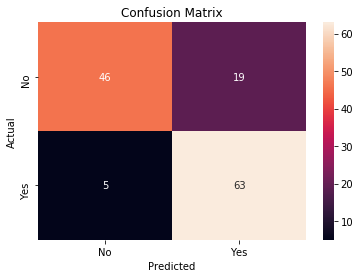

In [46]:
ax=plt.subplot()
sns.heatmap(cm,annot=True,ax=ax)# annot true anote the cells
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['No','Yes'])
ax.yaxis.set_ticklabels(['No','Yes'])

In [47]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=3,shuffle=True,random_state=0)
cvscore=[]
for train_index, test_index in kfold.split(X, y): #generator ## each time generates list of indices
    classifier=Sequential()
    classifier.add(Dense(200,activation='relu',kernel_initializer='random_normal',input_dim=X.shape[1]))
    classifier.add(Dense(400,activation='relu',kernel_initializer='random_normal'))
    classifier.add(Dense(4,activation='relu',kernel_initializer='random_normal'))
    classifier.add(Dense(1,activation='sigmoid',kernel_initializer='random_normal'))
    classifier.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    #### as binary prediction so binary_cross entropy
    classifier.fit(X[train_index],y[train_index],batch_size=20,epochs=50,verbose=0)
    eval_model=classifier.evaluate(X[train_index],y[train_index])
    score=eval_model[1]*100
    cvscore.append(score)
    print(score)
print(np.mean(cvscore))

442/442 [==============================] - 1s 2ms/step
88.23529398279493
442/442 [==============================] - 1s 2ms/step
86.65158376434809
444/444 [==============================] - 1s 2ms/step
88.06306306306307
87.6499802700687


In [48]:
y_pred=classifier.predict(X_test)

max_th=get_pred_threshold(X_test,y_test,classifier)

y_pred=(y_pred>max_th)

cm=confusion_matrix(y_test,y_pred)


In [49]:
cm

array([[54, 11],
       [ 3, 65]], dtype=int64)

[Text(0, 0.5, 'No'), Text(0, 1.5, 'Yes')]

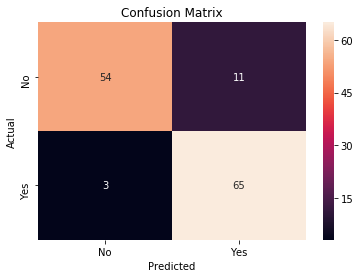

In [50]:
ax=plt.subplot()
sns.heatmap(cm,annot=True,ax=ax)# annot true anote the cells
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['No','Yes'])
ax.yaxis.set_ticklabels(['No','Yes'])

# Prediction

In [51]:
import pickle
from sklearn.externals import joblib
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE

In [52]:
###TODO Modifiable finction in Django
sc=joblib.load('scale_model.pkl')
model=joblib.load('loan_model.pkl')
max_th=joblib.load('maximum_th.pkl')
def fill_df(ip):
    ip_scaled=sc.transform(ip)   
    op=model.predict(ip_scaled)
    if(op>max_th):
        print('Loan Available')
    else:
        print('Loan Not Available')

In [53]:
dx=pd.read_csv('dummyx.csv')
dy=pd.read_csv('dummyy.csv')
for i in range(10):
    fill_df(np.array(dx.loc[i]).reshape(1,18))

Loan Available
Loan Available
Loan Available
Loan Available
Loan Available
Loan Available
Loan Not Available
Loan Available
Loan Not Available
Loan Available


In [54]:
max_th

0.35000000000000003